In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from model import AEDist
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
from torch.autograd import grad
adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint
import torch.optim as optim
from torch.autograd.functional import jacobian

from geodesic import jacobian, velocity, CondCurve, GeodesicBridgeDensity
from plotly3d.plot import  scatter, trajectories
import torch
from torch import nn
import pytorch_lightning as pl


In [2]:
wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [3]:
entity = "xingzhis"
project = "dmae"
# run_id = 'iio2bb24'
# run_id = 'djf8x1o1'
run_id = 'r4qvbc0l'
run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
data_path2 = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
data = np.load(data_path2, allow_pickle=True)
model = AEDist.load_from_checkpoint(ckpt_path)
x_tensor = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
# x_tensor_normalized = model.normalize(x_tensor)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [4]:
with torch.no_grad():
    z = model.encode(x_tensor)
    x_recon = model.decode(z)

In [5]:
scatter(z.cpu().numpy(), s=2)

/tmp/tmp.ARO5dTPRC2/ipykernel_964852/1344742883.py:12: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/tmp.ARO5dTPRC2/ipykernel_964852/1344742883.py:16: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.Size([1, 3])
torch.Size([20, 3])
torch.Size([20, 3])


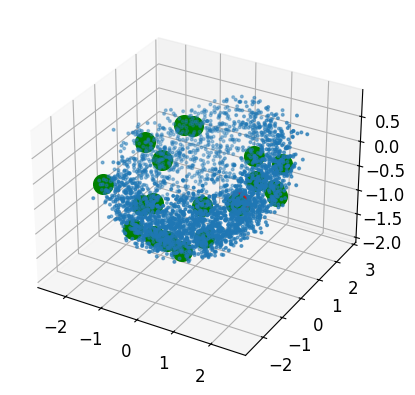

In [6]:
# Swiss roll random integer
# np.random.seed(3450)
# np.random.seed(3451)
# np.random.seed(3452)
np.random.seed(345123)
npts = len(z)
xs = []
n = 20
for i in range(n):
    start = np.random.randint(0,npts,size=1)
    # end = np.random.randint(0,npts,size=1)
    xs.append(torch.tensor(z[start,:]).cpu())
    # xends.append(torch.tensor(z[end,:]).cpu())
end = np.random.randint(0,npts,size=1)
# xfin = torch.tensor([[0,0,1]], dtype=torch.float32)
xfin = torch.tensor(z[end,:]).cpu() 
xbatch = torch.cat(xs,0)
endbtch = torch.cat([xfin for i in range(n)],0)

print(xfin.shape)
print(xbatch.shape)
print(endbtch.shape)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(z.detach().cpu().numpy(), ax=ax)
for i in range(xbatch.shape[0]):
    scprep.plot.scatter3d(xbatch[i].detach().cpu().numpy(), ax=ax, c='g')
    # scprep.plot.scatter2d(zhat_no_len_reg[:,i,:].detach().cpu().numpy(), ax=ax)
scprep.plot.scatter3d(xfin[0].detach().cpu().numpy(), ax=ax, c='r')
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(xbatch, endbtch)
dataloader = DataLoader(dataset, batch_size=len(xbatch), shuffle=True)

In [7]:
def func(z):
    return model.encode(model.decode(z))

In [12]:
gbmodel = GeodesicBridgeDensity(
    func=func,
    data_pts=z,
    input_dim=3, 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=3, 
    n_tsteps=1000, 
    lr=1e-3, 
    weight_decay=1e-5,
    density_weight=10.,
    euclidean=False
)
trainer = pl.Trainer(max_epochs=200)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type      | Params
-----------------------------------
0 | cc   | CondCurve | 10.9 K
-----------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [13]:
x0, x1 = next(iter(dataloader))
with torch.no_grad():
    zhat = gbmodel(x0, x1, gbmodel.ts)

In [14]:
# import torch
# import numpy as np

# # Constants
# n = 20  # Number of longitude lines, adjust as needed
# num_steps = 100  # Number of points per longitude line (time steps)

# # Generate angles
# theta = torch.linspace(0, np.pi / 2, num_steps).unsqueeze(1)  # Shape (100, 1)
# phi = torch.linspace(0, 2 * np.pi, n)  # Shape (n,)

# # Use broadcasting to generate full coordinates
# x = torch.sin(theta) * torch.cos(phi)  # Shape (100, n)
# y = torch.sin(theta) * torch.sin(phi)  # Shape (100, n)
# z = torch.cos(theta) * torch.ones(1, n)  # Shape (100, n)

# # Combine into a single tensor
# longitudelines = torch.stack((x, y, z), dim=-1)  # Final shape (100, n, 3)

# # Check the shape
# # print("Shape of points tensor:", points.shape)


In [15]:
fig = scatter(z.cpu().numpy(), s=2)
fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
# fig = trajectories(longitudelines.detach().cpu().numpy(), s=5, c='blue', fig=fig)
fig = trajectories(zhat.detach().cpu().numpy(), s=10, fig=fig, title='Geodesic Bridge (Encoder-decoder, density loss)', filename='hsphere_geod_dec_enc.html')
fig.show()